In [182]:
using Pkg

Pkg.activate("..")

using SymPy, DifferentialEquations, Plots, Statistics, Distributions, LaTeXStrings

include("./HelperScripts/temp_assembly.jl")

 Activating environment at `~/Projects/Working/Temperature_feasibility/Project.toml`


mean_no_diag (generic function with 1 method)

# Introduction

In this notebook I will solve the mean-field model for equlibrial biomass and demonstrate its suitability as an approximation of Lotka-Volterra dynamics. 

# Solving the mean-field model

To solve the mean-field model we first define the vairables to be used:

In [183]:
#define vairables and thier avarge counterparts
x,ux = symbols("x,μ_x")
r,ur = symbols("r,μ_r")
aii,uaii = symbols("a_{ii},μ_{a_{ii}}")
N, ua = symbols("N, μ_{a}")

#define mean-field to solve
f = r - aii*x + (N-1)ua*ux

x_sol = SymPy.solve(f, x)[1]

N⋅μₓ⋅μ_{a} + r - μₓ⋅μ_{a}
─────────────────────────
          a_{ii}         

In [184]:
#take average
ux_f1 = subs(x_sol , r =>ur , aii => uaii, ) - ux
ux_sol = SymPy.solve(ux_f1, ux)[1]

              μᵣ             
─────────────────────────────
-N⋅μ_{a} + μ_{a_{ii}} + μ_{a}

In [185]:
x_sol_final = subs(x_sol, ux => ux_sol).simplify()

N⋅μᵣ⋅μ_{a} + r⋅(-N⋅μ_{a} + μ_{a_{ii}} + μ_{a}) - μᵣ⋅μ_{a}
─────────────────────────────────────────────────────────
          a_{ii}⋅(-N⋅μ_{a} + μ_{a_{ii}} + μ_{a})         

which with some manual rearanging and observation of the fact that in isolation (i.e. $\bar{a} = 0$) a species equilbirium biomass is given by: 
$$
C_i^* = \frac{r_i}{a_{ii}} = K_i
$$

gives biomass as:

$$
C_i^* = K_i + \bar{K} \frac{ \frac{\mu_a}{a_{ii}}(N-1) }{ 1 - \frac{\mu_a}{a_{ii}}(N-1)}
$$

## Feasibility

taking this the equation for biomass above we can obtain an expression for feasability by enforcing the condition:

$$
x > 0 \quad \text{for all} \quad i = 1,2,\dots, N
$$

which gives the expression

$$
\frac{K_i}{\bar{K}}>  \frac{ \frac{\mu_a}{a_{ii}}(N-1) }{ \frac{\mu_a}{a_{ii}}(N-1) - 1}
$$

Here I simulate randomly generated systems to show that this bound applies to the lottka-volterra system (if the assumptions of the mean-field are met). Note that I keep intraspecific interactions constant ($a_{ii} = 1$) to aid in the interpretation. 

In [186]:
#analytical bound
function bound(N,ā) 
    (ā*(N-1)) / ( (ā*(N-1)) - 1 )
end

#generate random communtiy
function generate_parameters(N, a_μ, r_σ)
    r = rand(Distributions.TruncatedNormal(1.0,r_σ,0.0,Inf), N)
    a = rand(Distributions.Normal( a_μ/N , 20.0/(N*N)),N,N)
    [a[i,i] = -1.0 for i = 1:N]
    Param(N,r,a,0.0)
end

#simulation parameters
N = 50
x0 = rand(N) * 0.1
tspan = (0, 1e10)

# #replicate parameters
N_a, N_r, N_rep = 25 , 25 , 2
a_vec = range(-2.0, 0.0, length = N_a)
r_vec = range(0.0, 1.0, length = N_r)

# #results array
feas_results = Array{Tuple{Float64,Vector{Float64},Vector{Bool}},3}(undef, N_a, N_r, N_rep)

for i = 1:N_a, j = 1:N_r, k = 1:N_rep
    p = generate_parameters(N,a_vec[i],r_vec[j])    
    prob = ODEProblem(dx!, x0  , tspan, p)
    sol = DifferentialEquations.solve(prob)
    
    #realised parameters
    a = mean(sum(p.a,dims=2).+1) / (p.N-1)
    r = p.r ./ mean(p.r)
    
    feas_results[i,j,k] = a,r, sol[end] .> eps()
end

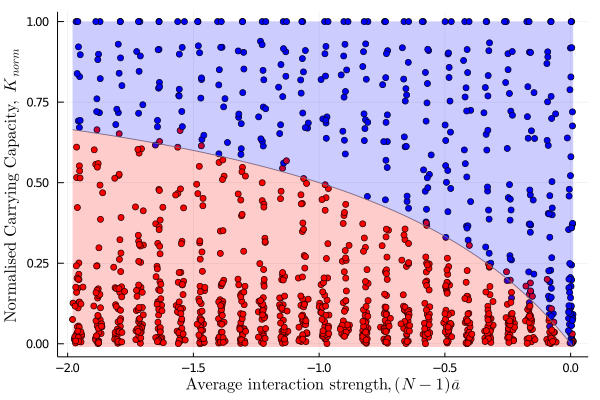

In [187]:
#plotting
#setup plotting arrays
x = [ feas_results[:][i][1] for i = 1:(N_a*N_r*N_rep) ]


y = [minimum(feas_results[:][i][2]) for i = 1:(N_a*N_r*N_rep)]
y = vcat(y...)

c = [all(feas_results[:][i][3]) for i = 1:(N_a*N_r*N_rep)]
c = vcat(c...)


col = fill(:red, N_a*N_r*N_rep)
col[c] .= :blue

p1 = scatter(x .* (N-1),y,color = col,
    ylab = L"\textrm{Normalised Carrying Capacity}, \ K_{norm}",
    xlab = L"\textrm{Average interaction strength},(N-1)\bar{a}")

xrange = range(minimum(x),maximum(x),length = 100)

plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "grey", lw = 0.9)
plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "Black", lw = 0, legend = false,fill = (-0.01,0.2,:red))
plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "Black", lw = 0, legend = false,fill = (1,0.2,:blue))

In [ ]:
savefig(p1, "")